In [ ]:
1. get filelist of orthophotos over Helsinki from Paituli
2. check email, download filelist
3. use wget -i filelist to download files (did not work for me directly; downloaded one by one with wget)
4. -> GeoML/data/orthophotos
5. same for MTK (whole Finland); takes minutes, better provide already clipped version on Allas or OSM
6. -> GeoML/data/MTK

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


array([ 384608.52127711, 6671087.70303994,  385876.41195862,
       6672366.52083272])

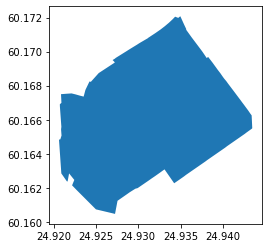

In [23]:
# Specify the name that is used to seach for the data
place_name = "Kamppi, Helsinki, Finland"
# import osmnx
import osmnx as ox
import geopandas as gpd

# Get place boundary related to the place name as a geodataframe
area = ox.geocode_to_gdf(place_name)
# Check the data type
area
area.plot()
area.bounds
area.crs
areaETRS = area.to_crs({'init':'epsg:3067'})
areaETRS.total_bounds

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/CSC_CONTAINER/minic

<AxesSubplot:>

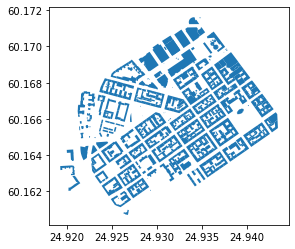

In [4]:
# List key-value pairs for tags
tags = {'building': True}   

buildings = ox.geometries_from_place(place_name, tags)
buildings.head()
# Plot footprints 
buildings.plot()

In [7]:
# List key-value pairs for tags
tags = {'natural': 'wood'}   

wood = ox.geometries_from_place(place_name, tags)
wood.head()
# Plot footprints 
wood.plot()

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<AxesSubplot:>

ValueError: cannot convert float NaN to integer

<Figure size 432x288 with 1 Axes>

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:>

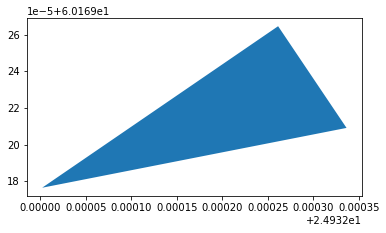

In [8]:
# List key-value pairs for tags
tags = {'natural': 'water'}   

water = ox.geometries_from_place(place_name, tags)
water.head()
# Plot footprints 
water.plot()

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:>

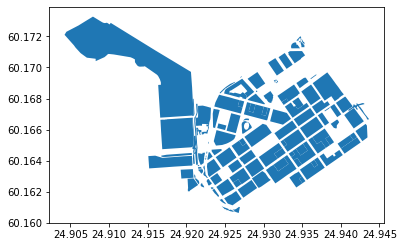

In [9]:
# List key-value pairs for tags
tags = {'landuse': True}   

landuse = ox.geometries_from_place(place_name, tags)
landuse.head()
# Plot footprints 
landuse.plot()

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:>

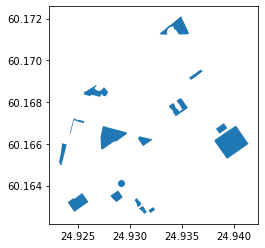

In [10]:
# List key-value pairs for tags
tags = {'leisure': 'park'}   

park = ox.geometries_from_place(place_name, tags)
park.head()
# Plot footprints 
park.plot()

In [19]:
# merge all orthophotos
from osgeo import gdal 
my_vrt = gdal.BuildVRT('my.vrt', ['../data/orthophotos/L4133A.jp2', '../data/orthophotos/L4133B.jp2', '../data/orthophotos/L4133C.jp2', '../data/orthophotos/L4133D.jp2'])
#write to disk
my_vrt = None

AttributeError: 'Dataset' object has no attribute 'crs'

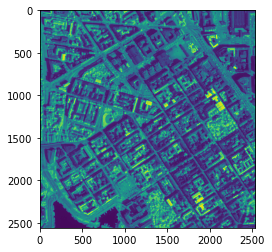

In [1]:
import rasterio
from rasterio.windows import from_bounds
from matplotlib import pyplot
vrt_path = "my.vrt"
with rasterio.open(vrt_path) as src:
    rst = src.read(window=from_bounds(384608.52127711, 6671087.70303994,  385876.41195862,
       6672366.52083272, src.transform))
    pyplot.imshow(rst[0])

In [ ]:
# create class vectorfile
water, park/grass/vegetation, building, streets?
-> look for largerpart/full of helsinki with all of them; run the model later on different part of Helsinki or other city Turku/Tampere and then totally different 
same with Sentinel-2 image?
-> create raster with classes
